In [127]:
import pandas as pd
import numpy as np 
import time
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score     
from sklearn.model_selection import train_test_split 
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingRegressor 
from matplotlib.pyplot import MultipleLocator
from sklearn.model_selection import RandomizedSearchCV
import warnings
import os 
import string 
import torch
warnings.filterwarnings("ignore")

In [128]:
# Read data
df = pd.read_excel('../../Feature_CO.xlsx', sheet_name= "ML_features")
features = df.iloc[:,:-1]

selected_features = ['$\\mathregular{χ_{NM(3-4)}}$',
 '$\\mathregular{m_{NM(4-5)}}$',
 '$\\mathregular{χ_{NM(0-3)}}$-$\\mathregular{χ_{M}}$',
 '$\\mathregular{χ_{NM(3-4)}}$-$\\mathregular{χ_{M}}$',
 'Z',
 '$\\mathregular{r_{M}}$',
 '$\\mathregular{EA_{M}}$',]


# selected features after feature recursive elimination
selected_columns = features[selected_features]
selected_columns
features = selected_columns
features

,$\mathregular{χ_{NM(3-4)}}$,$\mathregular{m_{NM(4-5)}}$,$\mathregular{χ_{NM(0-3)}}$-$\mathregular{χ_{M}}$,$\mathregular{χ_{NM(3-4)}}$-$\mathregular{χ_{M}}$,Z,$\mathregular{r_{M}}$,$\mathregular{EA_{M}}$
0,2.639091,13.175333,1.680000,1.279091,21,184,0.188
1,2.648000,13.009000,1.500000,1.108000,22,176,0.079
2,2.672500,13.009000,1.246667,1.042500,23,171,0.524
3,2.672500,13.009000,1.216667,1.012500,24,166,0.666
4,2.648000,13.009000,1.490000,1.098000,25,161,0.000
...,...,...,...,...,...,...,...
103,2.672500,12.343667,0.976667,0.772500,75,188,0.150
104,2.672500,12.343667,0.676667,0.472500,76,185,1.100
105,2.672500,12.343667,0.676667,0.472500,77,180,1.570
106,2.672500,12.343667,0.596667,0.392500,78,177,2.128


# Hyperparameter tuning

In [129]:
# Instantiate regressor algorithms
GBR = GradientBoostingRegressor(random_state=42)
model = GBR

# Feature normalization (standardize the descriptor)
features = (features - features.mean(axis=0)) / features.std(axis=0)
X_train, X_test, y_train, y_test = train_test_split(features, target_CO, train_size= 0.8, random_state=45)       

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

model_grid = {'loss':['ls', 'lad', 'huber', 'quantile'],
             'n_estimators': [10,50,100],
             'learning_rate':[0.05, 0.1, 0.15],
             'max_depth':[2,3,4],
             'min_samples_split':[2,3,5],
             'min_samples_leaf':[1,2,4]}
model.get_params().keys()

model_grid_cv = RandomizedSearchCV(estimator=model,
                        param_distributions=model_grid,
                        n_iter=100,
                        cv=10,
                        verbose= True)
model_grid_cv.fit(X_train,y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=100,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.15],
                                        'loss': ['ls', 'lad', 'huber',
                                                 'quantile'],
                                        'max_depth': [2, 3, 4],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 3, 5],
                                        'n_estimators': [10, 50, 100]},
                   verbose=True)

In [130]:
model_optimized = model_grid_cv.best_estimator_

# feature importance 

7
[0.0555087  0.09326567 0.09464898 0.10388491 0.18778303 0.19321139
 0.27169732]
['$\\mathregular{EA_{M}}$'
 '$\\mathregular{χ_{NM(3-4)}}$-$\\mathregular{χ_{M}}$'
 '$\\mathregular{χ_{NM(3-4)}}$' '$\\mathregular{m_{NM(4-5)}}$'
 '$\\mathregular{r_{M}}$'
 '$\\mathregular{χ_{NM(0-3)}}$-$\\mathregular{χ_{M}}$' 'Z']


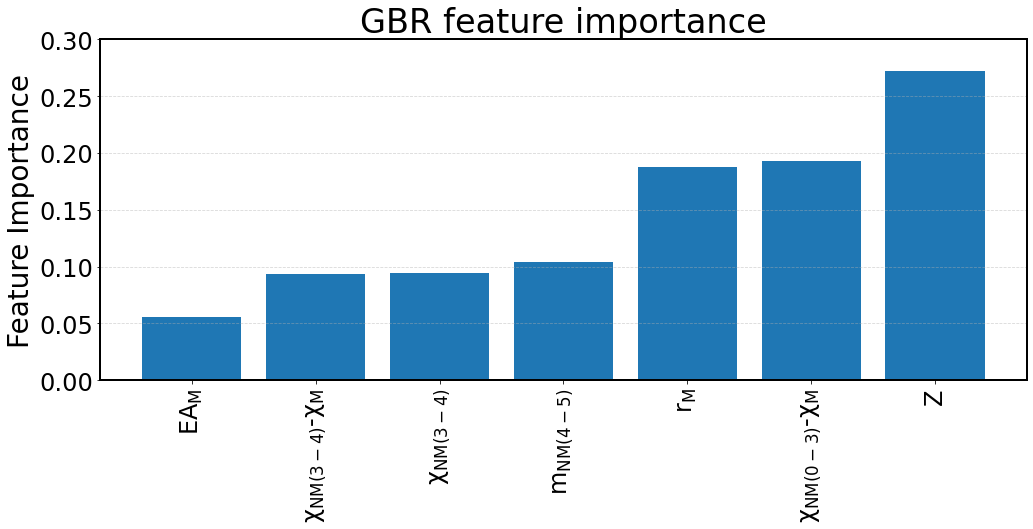

In [139]:
importances = model_optimized.feature_importances_
headers = features.columns.values.tolist()
print (len(headers))

sorted_idx = np.argsort(importances)
sorted_idx

importances_2 = importances[sorted_idx]
print (importances_2)

headers_2 = np.array(headers)[sorted_idx]
# headers = headers[len(headers)]
print (headers_2)

fig, ax = plt.subplots( figsize=(15, 8))


font={'weight':'normal', 
      'size': 28}
plt.rc('font', **font)


# ax.barh(importances_2,
#         headers_2,
#         height=0.7)

plt.bar(headers_2, importances_2,)

# ax.set_xlabel("Feature Importance", fontsize = 28)
ax.set_ylabel("Feature Importance", fontsize = 28)
ax.tick_params(axis='y', )
ax.tick_params(axis='x', rotation = 90)

plt.tick_params(labelsize=24)

ax.spines['bottom'].set_linewidth(2);
ax.spines['left'].set_linewidth(2);  
ax.spines['right'].set_linewidth(2); 
ax.spines['top'].set_linewidth(2); 
plt.title('GBR feature importance')
# plt.title('$\mathregular{χ_{NM}}$(4-5)-χ_M')
plt.grid(axis='y', ls='--', alpha=0.5)


ax.set_ylim(0, 0.30)

plt.tight_layout()
fig.savefig('Feature importance_all-heng.jpeg', dpi=600,)
fig.savefig('Feature importance_all-heng.svg',format='svg', bbox_inches='tight',)

# 500 trials repeat 

In [146]:
# Initialize lists to store metrics for training and testing
R2_2nd = []
RMSE_2nd = []
R2_2nd_test = []
RMSE_2nd_test = []

# Run the experiment 500 times
print('--- start 500 trials repeat ---')
for i in range(500):
    # Randomly split data
    X_train, X_test, y_train, y_test = train_test_split(features, target_CO, train_size=0.8)
    
    # Predictions and evaluation for training set
    y_tr_pred = model_optimized.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(y_tr_pred, y_train))
    R_squr_train = r2_score(y_train, y_tr_pred)
    
    #print('RMSE for training (v2): {:.4f} eV'.format(rmse_train))
    #print('R^2 for train {:.4f}'.format(R_squr_train))
    
    # Store metrics for training set
    RMSE_2nd.append(rmse_train)
    R2_2nd.append(R_squr_train)
    
    # Predictions and evaluation for testing set
    y_te_pred = model_optimized.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_te_pred, y_test))
    R_squr_test = r2_score(y_test, y_te_pred)
    
    #print('RMSE for testing (v2): {:.4f} eV'.format(rmse_test))
    #print('R^2 for test {:.4f}'.format(R_squr_test))
    
    # Store metrics for testing set
    RMSE_2nd_test.append(rmse_test)
    R2_2nd_test.append(R_squr_test)

# Create DataFrames from the collected metrics
text1 = pd.DataFrame({'gbr-rmse': RMSE_2nd})
text2 = pd.DataFrame({'gbr-r2': R2_2nd})
text3 = pd.DataFrame({'gbr-rmse_test': RMSE_2nd_test})
text4 = pd.DataFrame({'gbr-r2_test': R2_2nd_test})

# Calculate and print average values for training set
avg_rmse_train = np.mean(RMSE_2nd)
avg_r2_train = np.mean(R2_2nd)

print('Average RMSE for training set: {:.3f} eV'.format(avg_rmse_train))
print('Average R^2 for training set: {:.3f}'.format(avg_r2_train))

# Calculate and print average values for testing set
avg_rmse_test = np.mean(RMSE_2nd_test)
avg_r2_test = np.mean(R2_2nd_test)

print('Average RMSE for testing set: {:.3f} eV'.format(avg_rmse_test))
print('Average R^2 for testing set: {:.3f}'.format(avg_r2_test))

--- start 500 trials repeat ---
Average RMSE for training set: 0.165 eV
Average R^2 for training set: 0.940
Average RMSE for testing set: 0.153 eV
Average R^2 for testing set: 0.937


In [147]:
# Concatenate DataFrames along columns
result_df = pd.concat([text1, text2, text3, text4], axis=1)

# Write the concatenated DataFrame to an Excel file
result_df.to_excel('GBR_500_trials_repeat_8D_CO.xlsx', index=False)  

# Optimized model for NO adsorption energy prediciton

In [150]:
# Read data
df2 = pd.read_excel('../../Feature_NO.xlsx', sheet_name= "ML_features")
target_NO = df2.iloc[:,-1]
features
model_optimized.fit(features, target_NO)
# features

GradientBoostingRegressor(learning_rate=0.15, loss='ls', min_samples_leaf=2,
                          min_samples_split=3, random_state=42)

RMSE for train: 0.0570 eV
R^2 for train 0.9802 eV
RMSE for test: 0.0511 eV
R^2 for test 0.9812 eV


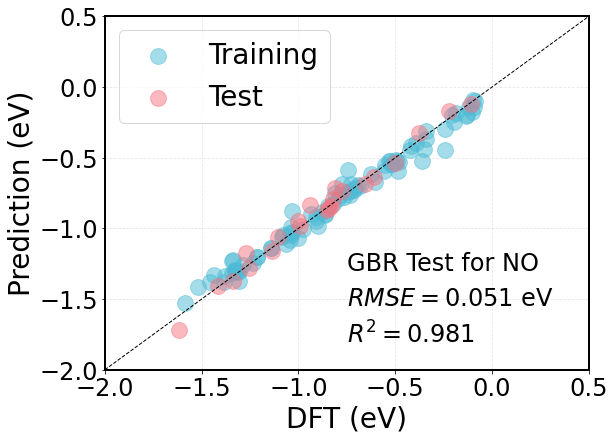

In [151]:
X_train, X_test, y_train, y_test = train_test_split(features, target_NO, train_size= 0.8, random_state=45) 


y_tr_pred = model_optimized.predict(X_train)
y_te_pred = model_optimized.predict(X_test)

RMSE = np.sqrt(mean_squared_error(y_tr_pred, y_train))
print('RMSE for train: {:.4f} eV'.format(RMSE))
R_squr_train = r2_score(y_train, y_tr_pred)
print ('R^2 for train {:.4f} eV'.format(R_squr_train))

RMSE = np.sqrt(mean_squared_error(y_te_pred, y_test))
print('RMSE for test: {:.4f} eV'.format(RMSE))
R_squr = r2_score(y_test, y_te_pred)
print ('R^2 for test {:.4f} eV'.format(R_squr))



font = {'size': '28'}
plt.rc('font', **font)

fig, ax = plt.subplots(figsize=(8.67, 6.5))
ax.scatter(y_train, y_tr_pred, alpha=0.5, c='#4DBBD5', marker='o', label='Training', s=250)
ax.scatter(y_test, y_te_pred, alpha=0.5, c='#f67280', marker='o', label='Test', s=250)

plt.xlim(-2, 0.5)
plt.ylim(-2, 0.5)

ax.set_xlabel('DFT (eV)')
ax.set_ylabel('Prediction (eV)')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, 
        scalex=False, scaley=False)


y_major_locator=MultipleLocator(0.5)
ax.yaxis.set_major_locator(y_major_locator)
x_major_locator=MultipleLocator(0.5)
ax.xaxis.set_major_locator(x_major_locator)
plt.tick_params(labelsize=24)

ax.spines['bottom'].set_linewidth(2);
ax.spines['left'].set_linewidth(2);  
ax.spines['right'].set_linewidth(2); 
ax.spines['top'].set_linewidth(2); 


plt.grid(axis='x', ls='--', alpha=0.3)
plt.grid(axis='y', ls='--', alpha=0.3)


plt.text(0.5, 0.3, 'GBR Test for NO', horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes, fontsize=24)
plt.text(0.5, 0.2, '$RMSE = %0.3f$ eV'% RMSE, horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes, fontsize=24)
plt.text(0.5, 0.1, '$R^2 = %0.3f$'% R_squr, horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes,fontsize=24)

plt.legend(loc=0)
# plt.title('GBR')
plt.savefig('./NO.jpg', dpi=600, bbox_inches='tight')
plt.savefig('NO.svg',format='svg', bbox_inches='tight',)
plt.show()

In [152]:
# Initialize lists to store metrics for training and testing
R2_2nd = []
RMSE_2nd = []
R2_2nd_test = []
RMSE_2nd_test = []
for i in range(0,500):
    # Randomly split data
    X_train, X_test, y_train, y_test = train_test_split(features, target_NO, train_size= 0.8) 

    # Predictions and evaluation for training set
    y_tr_pred = model_optimized.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(y_tr_pred, y_train))
    R_squr_train = r2_score(y_train, y_tr_pred)
    
    #print('RMSE for training (v2): {:.4f} eV'.format(rmse_train))
    #print('R^2 for train {:.4f}'.format(R_squr_train))
    
    # Store metrics for training set
    RMSE_2nd.append(rmse_train)
    R2_2nd.append(R_squr_train)
    
    # Predictions and evaluation for testing set
    y_te_pred = model_optimized.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_te_pred, y_test))
    R_squr_test = r2_score(y_test, y_te_pred)
    
    #print('RMSE for testing (v2): {:.4f} eV'.format(rmse_test))
    #print('R^2 for test {:.4f}'.format(R_squr_test))
    
    # Store metrics for testing set
    RMSE_2nd_test.append(rmse_test)
    R2_2nd_test.append(R_squr_test)

    
# mean_R2_2nd = np.mean(R2_2nd)
# mean_R2_2nd

text1 = pd.DataFrame({'gbr-rmse':RMSE_2nd})
text2 = pd.DataFrame({'gbr-r2':R2_2nd})
text3 = pd.DataFrame({'gbr-rmse_test':RMSE_2nd_test})
text4 = pd.DataFrame({'gbr-r2_test':R2_2nd_test})

# Calculate and print average values for training set
avg_rmse_train = np.mean(RMSE_2nd)
avg_r2_train = np.mean(R2_2nd)

print('Average RMSE for training set: {:.4f} eV'.format(avg_rmse_train))
print('Average R^2 for training set: {:.4f}'.format(avg_r2_train))

# Calculate and print average values for testing set
avg_rmse_test = np.mean(RMSE_2nd_test)
avg_r2_test = np.mean(R2_2nd_test)

print('Average RMSE for testing set: {:.4f} eV'.format(avg_rmse_test))
print('Average R^2 for testing set: {:.4f}'.format(avg_r2_test))

--- start 500 trails repeat ---
Average RMSE for training set: 0.0558 eV
Average R^2 for training set: 0.9805
Average RMSE for testing set: 0.0545 eV
Average R^2 for testing set: 0.9790


In [153]:
# Concatenate DataFrames along columns
result_df = pd.concat([text1, text2, text3, text4], axis=1)

# Write the concatenated DataFrame to an Excel file
result_df.to_excel('500_trials_repeat_NO.xlsx', index=False)

# Optimized model for OH adsorption energy prediciton

In [154]:
# Optimized model for NO adsorption energy prediciton# Read data
df3 = pd.read_excel('../../Feature_OH.xlsx', sheet_name= "ML_features")
target_OH = df3.iloc[:,-1]
features
model_optimized.fit(features, target_OH)

GradientBoostingRegressor(learning_rate=0.15, loss='ls', min_samples_leaf=2,
                          min_samples_split=3, random_state=42)

RMSE for train: 0.1029 eV
R^2 for train 0.9914 eV
RMSE for test: 0.1019 eV
R^2 for test 0.9930 eV


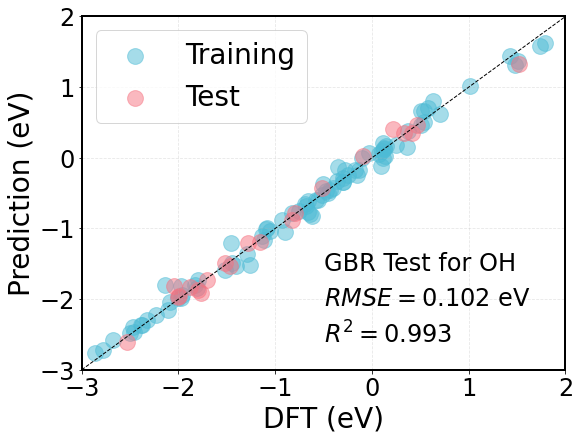

In [155]:
X_train, X_test, y_train, y_test = train_test_split(features, target_OH, train_size= 0.8, random_state=45) 


y_tr_pred = model_optimized.predict(X_train)
y_te_pred = model_optimized.predict(X_test)

RMSE = np.sqrt(mean_squared_error(y_tr_pred, y_train))
print('RMSE for train: {:.4f} eV'.format(RMSE))
R_squr_train = r2_score(y_train, y_tr_pred)
print ('R^2 for train {:.4f} eV'.format(R_squr_train))

RMSE = np.sqrt(mean_squared_error(y_te_pred, y_test))
print('RMSE for test: {:.4f} eV'.format(RMSE))
R_squr = r2_score(y_test, y_te_pred)
print ('R^2 for test {:.4f} eV'.format(R_squr))


font = {'size': '28'}
plt.rc('font', **font)

fig, ax = plt.subplots(figsize=(8.67, 6.5))
ax.scatter(y_train, y_tr_pred, alpha=0.5, c='#4DBBD5', marker='o', label='Training', s=250)
ax.scatter(y_test, y_te_pred, alpha=0.5, c='#f67280', marker='o', label='Test', s=250)

plt.xlim(-3, 2)
plt.ylim(-3, 2)

ax.set_xlabel('DFT (eV)')
ax.set_ylabel('Prediction (eV)')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, 
        scalex=False, scaley=False)


y_major_locator=MultipleLocator(1)
ax.yaxis.set_major_locator(y_major_locator)
x_major_locator=MultipleLocator(1)
ax.xaxis.set_major_locator(x_major_locator)
plt.tick_params(labelsize=24)

ax.spines['bottom'].set_linewidth(2);
ax.spines['left'].set_linewidth(2);  
ax.spines['right'].set_linewidth(2); 
ax.spines['top'].set_linewidth(2); 


plt.grid(axis='x', ls='--', alpha=0.3)
plt.grid(axis='y', ls='--', alpha=0.3)


plt.text(0.5, 0.3, 'GBR Test for OH', horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes, fontsize=24)
plt.text(0.5, 0.2, '$RMSE = %0.3f$ eV'% RMSE, horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes, fontsize=24)
plt.text(0.5, 0.1, '$R^2 = %0.3f$'% R_squr, horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes,fontsize=24)

plt.legend(loc=0)
# plt.title('GBR')
plt.savefig('./OH.jpg', dpi=600, bbox_inches='tight')
plt.savefig('OH.svg',format='svg', bbox_inches='tight',)
plt.show()

In [156]:
# Initialize lists to store metrics for training and testing
R2_2nd = []
RMSE_2nd = []
R2_2nd_test = []
RMSE_2nd_test = []
for i in range(0,500):
    # Randomly split data
    X_train, X_test, y_train, y_test = train_test_split(features, target_OH, train_size= 0.8) 

    # Predictions and evaluation for training set
    y_tr_pred = model_optimized.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(y_tr_pred, y_train))
    R_squr_train = r2_score(y_train, y_tr_pred)
    
    #print('RMSE for training (v2): {:.4f} eV'.format(rmse_train))
    #print('R^2 for train {:.4f}'.format(R_squr_train))
    
    # Store metrics for training set
    RMSE_2nd.append(rmse_train)
    R2_2nd.append(R_squr_train)
    
    # Predictions and evaluation for testing set
    y_te_pred = model_optimized.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_te_pred, y_test))
    R_squr_test = r2_score(y_test, y_te_pred)
    
    #print('RMSE for testing (v2): {:.4f} eV'.format(rmse_test))
    #print('R^2 for test {:.4f}'.format(R_squr_test))
    
    # Store metrics for testing set
    RMSE_2nd_test.append(rmse_test)
    R2_2nd_test.append(R_squr_test)
    
# mean_R2_2nd = np.mean(R2_2nd)
# mean_R2_2nd

text1 = pd.DataFrame({'gbr-rmse':RMSE_2nd})
text2 = pd.DataFrame({'gbr-r2':R2_2nd})
text3 = pd.DataFrame({'gbr-rmse_test':RMSE_2nd_test})
text4 = pd.DataFrame({'gbr-r2_test':R2_2nd_test})

# Calculate and print average values for training set
avg_rmse_train = np.mean(RMSE_2nd)
avg_r2_train = np.mean(R2_2nd)

print('Average RMSE for training set: {:.4f} eV'.format(avg_rmse_train))
print('Average R^2 for training set: {:.4f}'.format(avg_r2_train))

# Calculate and print average values for testing set
avg_rmse_test = np.mean(RMSE_2nd_test)
avg_r2_test = np.mean(R2_2nd_test)

print('Average RMSE for testing set: {:.4f} eV'.format(avg_rmse_test))
print('Average R^2 for testing set: {:.4f}'.format(avg_r2_test))

---start 500 trails repeat  ---
Average RMSE for training set: 0.1026 eV
Average R^2 for training set: 0.9917
Average RMSE for testing set: 0.1016 eV
Average R^2 for testing set: 0.9910


In [157]:
# Concatenate DataFrames along columns
result_df = pd.concat([text1, text2, text3, text4], axis=1)

# Write the concatenated DataFrame to an Excel file
result_df.to_excel('500_trials_repeat_OH.xlsx', index=False)

# Optimized model for N2 adsorption energy prediciton

RMSE for train: 0.0776 eV
R^2 for train 0.9644 eV
RMSE for test: 0.0623 eV
R^2 for test 0.9720 eV


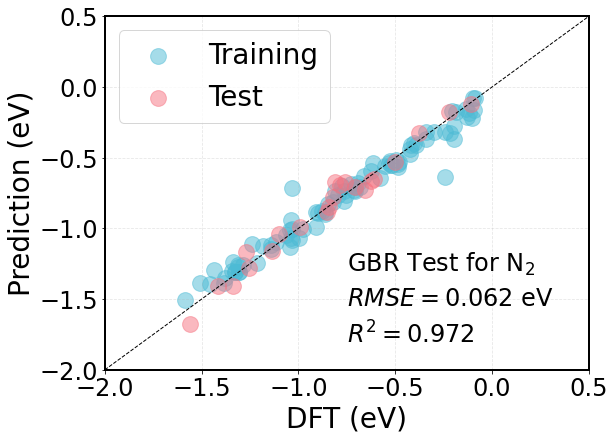

In [158]:
# Read data
df4 = pd.read_excel('../../Feature_N2.xlsx', sheet_name= "ML_features")
target_N2 = df4.iloc[:,-1]
features
model_optimized.fit(features, target_N2)

X_train, X_test, y_train, y_test = train_test_split(features, target_N2, train_size= 0.8, random_state=45) 

# 开始做测试
y_tr_pred = model_optimized.predict(X_train)
y_te_pred = model_optimized.predict(X_test)

RMSE = np.sqrt(mean_squared_error(y_tr_pred, y_train))
print('RMSE for train: {:.4f} eV'.format(RMSE))
R_squr_train = r2_score(y_train, y_tr_pred)
print ('R^2 for train {:.4f} eV'.format(R_squr_train))

RMSE = np.sqrt(mean_squared_error(y_te_pred, y_test))
print('RMSE for test: {:.4f} eV'.format(RMSE))
R_squr = r2_score(y_test, y_te_pred)
print ('R^2 for test {:.4f} eV'.format(R_squr))

# 画图  
font = {'size': '28'}
plt.rc('font', **font)

fig, ax = plt.subplots(figsize=(8.67, 6.5))
ax.scatter(y_train, y_tr_pred, alpha=0.5, c='#4DBBD5', marker='o', label='Training', s=250)
ax.scatter(y_test, y_te_pred, alpha=0.5, c='#f67280', marker='o', label='Test', s=250)

plt.xlim(-2, 0.5)
plt.ylim(-2, 0.5)

ax.set_xlabel('DFT (eV)')
ax.set_ylabel('Prediction (eV)')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, 
        scalex=False, scaley=False)


y_major_locator=MultipleLocator(0.5)
ax.yaxis.set_major_locator(y_major_locator)
x_major_locator=MultipleLocator(0.5)
ax.xaxis.set_major_locator(x_major_locator)
plt.tick_params(labelsize=24)

ax.spines['bottom'].set_linewidth(2);
ax.spines['left'].set_linewidth(2);  
ax.spines['right'].set_linewidth(2); 
ax.spines['top'].set_linewidth(2); 


plt.grid(axis='x', ls='--', alpha=0.3)
plt.grid(axis='y', ls='--', alpha=0.3)


plt.text(0.5, 0.3, 'GBR Test for N$_2$', horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes, fontsize=24)
plt.text(0.5, 0.2, '$RMSE = %0.3f$ eV'% RMSE, horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes, fontsize=24)
plt.text(0.5, 0.1, '$R^2 = %0.3f$'% R_squr, horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes,fontsize=24)

plt.legend(loc=0)
# plt.title('GBR')
plt.savefig('./N2.jpg', dpi=600, bbox_inches='tight')
plt.savefig('N2.svg',format='svg', bbox_inches='tight',)
plt.show()

In [159]:
# Initialize lists to store metrics for training and testing
R2_2nd = []
RMSE_2nd = []
R2_2nd_test = []
RMSE_2nd_test = []
for i in range(0,500):
    # Randomly split data
    X_train, X_test, y_train, y_test = train_test_split(features, target_N2, train_size= 0.8) 

    # Predictions and evaluation for training set
    y_tr_pred = model_optimized.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(y_tr_pred, y_train))
    R_squr_train = r2_score(y_train, y_tr_pred)
    
    #print('RMSE for training (v2): {:.4f} eV'.format(rmse_train))
    #print('R^2 for train {:.4f}'.format(R_squr_train))
    
    # Store metrics for training set
    RMSE_2nd.append(rmse_train)
    R2_2nd.append(R_squr_train)
    
    # Predictions and evaluation for testing set
    y_te_pred = model_optimized.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_te_pred, y_test))
    R_squr_test = r2_score(y_test, y_te_pred)
    
    #print('RMSE for testing (v2): {:.4f} eV'.format(rmse_test))
    #print('R^2 for test {:.4f}'.format(R_squr_test))
    
    # Store metrics for testing set
    RMSE_2nd_test.append(rmse_test)
    R2_2nd_test.append(R_squr_test)
    
# mean_R2_2nd = np.mean(R2_2nd)
# mean_R2_2nd

text1 = pd.DataFrame({'gbr-rmse':RMSE_2nd})
text2 = pd.DataFrame({'gbr-r2':R2_2nd})
text3 = pd.DataFrame({'gbr-rmse_test':RMSE_2nd_test})
text4 = pd.DataFrame({'gbr-r2_test':R2_2nd_test})

# Calculate and print average values for training set
avg_rmse_train = np.mean(RMSE_2nd)
avg_r2_train = np.mean(R2_2nd)

print('Average RMSE for training set: {:.4f} eV'.format(avg_rmse_train))
print('Average R^2 for training set: {:.4f}'.format(avg_r2_train))

# Calculate and print average values for testing set
avg_rmse_test = np.mean(RMSE_2nd_test)
avg_r2_test = np.mean(R2_2nd_test)

print('Average RMSE for testing set: {:.4f} eV'.format(avg_rmse_test))
print('Average R^2 for testing set: {:.4f}'.format(avg_r2_test))

---start 500 trails repeat ---
Average RMSE for training set: 0.0744 eV
Average R^2 for training set: 0.9658
Average RMSE for testing set: 0.0717 eV
Average R^2 for testing set: 0.9637


In [161]:
# Concatenate DataFrames along columns
result_df = pd.concat([text1, text2, text3, text4], axis=1)

# Write the concatenated DataFrame to an Excel file
result_df.to_excel('500_trials_repeat_N2.xlsx', index=False)